In [1]:
#Description: 
#  This notebook uses LIME to make post-hoc explanations of classifications
#  LIME stands for local interpretable model-agnostic explanations 
#  see https://github.com/marcotcr/lime
#      https://arxiv.org/abs/1602.04938
#
#  Another alternative is to use SHAP (SHapley Additive exPlanations): https://github.com/slundberg/shap
#

# Setup

In [2]:
#imports

import numpy as np

import lime
from lime import lime_image

from skimage.segmentation import mark_boundaries


In [3]:
#import lime
import PIL.Image
import torch
import torchvision.models as models
import matplotlib.pyplot as plt


In [4]:
from torchvision import transforms
import torch.nn.functional as F


# Load Model and Parameters

In [5]:

# Load the Inception_v3 model.
model = models.inception_v3(pretrained=True)
#saved to /home/dm/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


/home/dm/miniconda3/envs/xai_n_xformer/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/dm/miniconda3/envs/xai_n_xformer/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
image_size=(299, 299) 
#image_size=(342, 342) # needed pytorch version according to https://github.com/pytorch/vision/issues/6066
#note: help(models.inception_v3) says
#**Important**: In contrast to the other models the inception_v3 expects tensors with a size of
#        N x 3 x 299 x 299, so ensure your images are sized accordingly.

# Form Preprocessing Function

In [7]:
#we need: (1) to take PIL image, resize and crop it, and (2) apply whitening

def get_pil_transform(): 
    transf = transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(299) #seems redundant but several examples do this
                                   #also seems better to crop & then resize, but again, all examples did reverse
    ])    
    return transf

pill_transf = get_pil_transform()



In [8]:
#inception preprocessing done to data -- consistent with several examples and pytorch discussion examples
#e.g., https://github.com/marcotcr/lime/blob/master/doc/notebooks/Tutorial%20-%20images%20-%20Pytorch.ipynb
#e.g., https://github.com/pytorch/vision/issues/6066 -- note numerous strange result issues brought up here though
def get_preprocess_transform(): #
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                      std=[0.229, 0.224, 0.225])     
    transf = transforms.Compose([
        transforms.ToTensor(),
        normalize #pytorch inception model's transform default is off, so do it here
    ])    

    return transf    
preprocess_transform = get_preprocess_transform()

# Experimental Preprocessing Function (uncomment to explore)

In [9]:
#experiment after examining
#https://github.com/pytorch/vision/blob/main/torchvision/models/inception.py#L95

#this should be a forward transform but looks more like an inverse (multiplies by std instead of divide etc.)
#also seems a bit /0.5-gung-ho? not sure what that's all about
#x_ch0 = torch.unsqueeze(x[:, 0], 1) * (0.229 / 0.5) + (0.485 - 0.5) / 0.5
#x_ch1 = torch.unsqueeze(x[:, 1], 1) * (0.224 / 0.5) + (0.456 - 0.5) / 0.5
#x_ch2 = torch.unsqueeze(x[:, 2], 1) * (0.225 / 0.5) + (0.406 - 0.5) / 0.5

#Assuming this is the inverse transform, lets compute the forward transform means and stds for the normalizer

#inn = 11.0 # example input, used for checking/testing
#
##transform -- actual form for x_ch2
#val = (inn * (0.225 / 0.5) ) +   ((0.406 - 0.5) / 0.5)
#
##transform -- desired form: (inn - m)/std   = inn/std   - m/std
##math steps below
#val2 = (inn * (0.225 * 2) ) +   ((0.406 - 0.5) * 2) #change /.5 to *2
#val2 = (inn * (0.225 * 2) ) +   (0.406*2 - 1)  
#std = (1/(0.225 * 2))
#val2 = inn / std  +   (0.406*2 - 1)*std / std
#m=(0.406*2 - 1)/(0.225 * 2)
#val2 = inn / std  +   m / std #desired form
#
##check if values are the same
#val , val2

In [10]:
#use proceedure above and check for each channel
s0=(1/(0.229 * 2)) #std
s1=(1/(0.224 * 2))
s2=(1/(0.225 * 2)) 
m0=(0.485*2 - 1)/(0.229 * 2) #mean
m1=(0.456*2 - 1)/(0.224 * 2)
m2=(0.406*2 - 1)/(0.225 * 2)


inn = 11.0 # example input, used for checking/testing
res0 = inn/s0 + m0/s0 == (inn * (0.229 / 0.5) ) +   ((0.485 - 0.5) / 0.5)
res1 = inn/s1 + m1/s1 == (inn * (0.224 / 0.5) ) +   ((0.456 - 0.5) / 0.5)
res2 = inn/s2 + m2/s2 == (inn * (0.225 / 0.5) ) +   ((0.406 - 0.5) / 0.5)
res0,res1,res2

(True, True, True)

In [11]:
#experiment to make more consistent with 
#https://github.com/pytorch/vision/blob/main/torchvision/models/inception.py#L95
#x_ch0 = torch.unsqueeze(x[:, 0], 1) * (0.229 / 0.5) + (0.485 - 0.5) / 0.5
#x_ch1 = torch.unsqueeze(x[:, 1], 1) * (0.224 / 0.5) + (0.456 - 0.5) / 0.5
#x_ch2 = torch.unsqueeze(x[:, 2], 1) * (0.225 / 0.5) + (0.406 - 0.5) / 0.5
def get_preprocess_transform_experimental():
    normalize = transforms.Normalize(mean=[m0,m1,m2],
                                      std=[s0,s1,s2])     
    transf = transforms.Compose([
        transforms.ToTensor(),
        normalize #pytorch inception model's transform default is off, so do it here
    ])    

    return transf    

#preprocess_transform = get_preprocess_transform_experimental()

# Form Inverse-processing Function

In [12]:
#inv_preprocess = lambda x: x
#Not needed since preprocessing is not applied to the image fed to explainer (it is returned in explanation). 
#This differs from tensorflow examples, where model preprocessing was done to image fed into the explainer.
#Here, model preprocessing, is acounted for in the prediction function instea.

# Load Data To Examine

In [13]:
n=56
image_path = "/home/dm/ml_n_code/sandbox/cats_vs_dogs/data/train/Cat/" + str(n)+".jpg"



In [14]:

image_pil = PIL.Image.open(image_path)


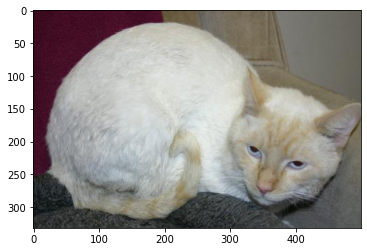

In [15]:
plt.imshow(image_pil) #plot image


# Predictions

In [16]:
def batch_predict(images):
    model.eval()
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    batch = batch.to(device)
    
    logits = model(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

In [17]:
test_pred = batch_predict([pill_transf(image_pil)])
test_pred.squeeze().argmax()

285

# Find Explanations

In [18]:
# Create a LIME explainer.

lime_explainer = lime_image.LimeImageExplainer()


In [19]:
# Compute explanation.

explanation = lime_explainer.explain_instance(    
    np.array(pill_transf(image_pil)), 
    batch_predict, # classification function
    top_labels=5, 
    hide_color=0, 
    num_samples=1000) # number of images that will be sent to classification function


  0%|          | 0/1000 [00:00<?, ?it/s]

# Class Labels

In [20]:
import os, json

class_dict = {}
with open(os.path.abspath('./hugface_imagenet_class_index.json'), 'r') as read_file:
    class_dict = json.load(read_file)
    

In [21]:
print('Predicted:')
for classIdx in explanation.top_labels:
        print(f"{classIdx,class_dict['id2label'][str(classIdx)]}")


Predicted:
(285, 'Egyptian cat')
(284, 'Siamese cat, Siamese')
(282, 'tiger cat')
(281, 'tabby, tabby cat')
(539, 'doormat, welcome mat')


# Explanation Plots

Text(0.5, 1.0, 'Explanation with Rest of Image')

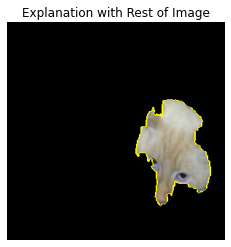

In [22]:
#see the explanation for the top class -- with the rest of the image present
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0], 
    positive_only=True, 
    num_features=5, 
    hide_rest=True
)

plt.imshow(mark_boundaries(temp.astype('uint8'), mask))
plt.axis("off")
plt.title('Explanation with Rest of Image')

Text(0.5, 1.0, 'Segmentation')

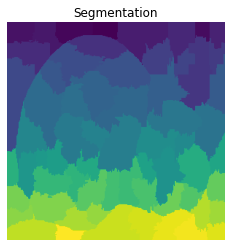

In [23]:
#show region segmentation
plt.figure()
plt.imshow(explanation.segments)
plt.axis("off")
plt.title('Segmentation')

Text(0.5, 1.0, 'Explanation Mask')

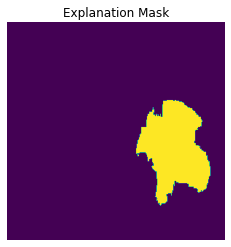

In [24]:
#show region label mask
plt.figure()
plt.imshow(mask)
plt.axis("off")
plt.title('Explanation Mask')

Text(0.5, 1.0, 'Explanation with Rest of Image')

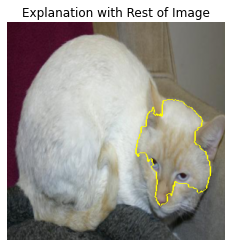

In [25]:
#see the explanation for the top class -- with the rest of the image present
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0], 
    positive_only=True, 
    num_features=5, 
    hide_rest=False
)

plt.imshow(mark_boundaries(temp.astype('uint8'), mask))
plt.axis("off")
plt.title('Explanation with Rest of Image')

Text(0.5, 1.0, 'Explanation Pros (Green) and Cons (Red)')

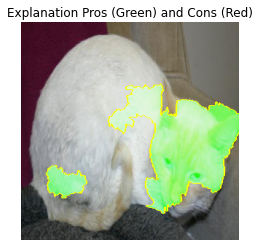

In [26]:
#see the 'pros and cons' (pros contributing to class call in green, cons in red)
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0], 
    positive_only=False, 
    num_features=10, 
    hide_rest=False)

plt.imshow(mark_boundaries(temp.astype('uint8'), mask))
plt.axis("off")
plt.title('Explanation Pros (Green) and Cons (Red)')

Text(0.5, 1.0, 'Explanation Heatmap')

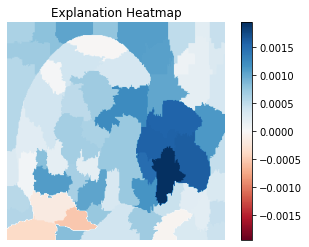

In [27]:
#explanation weights heatmap visualization

#Select the same class explained on the figures above.
ind =  explanation.top_labels[0]

#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 

#Plot. The visualization makes more sense if a symmetrical colorbar is used.
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()
plt.axis("off")
plt.title('Explanation Heatmap')

# Discussion of Results

In [28]:
#comparing to the tensorflow inception LIME results:
#1) it seems like heatmap is slightly different -- not much red and range different
#2) top predictions don't quite line up the same

#also, several issues, bugs, concerns have been brought up for inception pytorch implementation. maybe related?
#e.g., https://github.com/pytorch/vision/issues/6066 -- suggests resize with 342 is needed, but this didnt help
#e.g., https://github.com/pytorch/vision/issues/723 -- look like ticket still open? o.O

#furthermore, this looks a bit odd to me in inception pytorch code:
#https://github.com/pytorch/vision/blob/main/torchvision/models/inception.py#L95
#x_ch0 = torch.unsqueeze(x[:, 0], 1) * (0.229 / 0.5) + (0.485 - 0.5) / 0.5
#x_ch1 = torch.unsqueeze(x[:, 1], 1) * (0.224 / 0.5) + (0.456 - 0.5) / 0.5
#x_ch2 = torch.unsqueeze(x[:, 2], 1) * (0.225 / 0.5) + (0.406 - 0.5) / 0.5
#shouldn't this be a forward transform? It looks more like an inverse (multiplies by std instead of divide etc.)
#also seems a bit /0.5-gung-ho? not sure what that's all about; doesn't seem to match normalizaitons others used

#further testing is required to verify consistency with tensorflow and pytorch results for the same models